<a href="https://colab.research.google.com/github/vuhpham94/nflx-data-projects-g6/blob/main/project_final/notebooks/cnn_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies and connection

In [1]:
# gdrive connection
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
from tqdm import tqdm

import os
import pathlib
import PIL

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Load dataset

In [3]:
data_dir = '/content/drive/Shareddrives/FinalProject/yt_dataset'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

10614


In [4]:
batch_size = 32
img_height = 128
img_width = 128

## Training set

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10614 files belonging to 2 classes.
Using 8492 files for training.


## Validation set

In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10614 files belonging to 2 classes.
Using 2122 files for validation.


## Labels

In [7]:
class_names = train_ds.class_names
print(class_names)

['kid_friendly', 'not_kid_friendly']


In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


# CNN Models

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Outer model normalization (optional)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

## CNN model

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)       

In [21]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
266/266 [==============================] - 161s 553ms/step - loss: 0.6416 - accuracy: 0.6182 - val_loss: 0.5397 - val_accuracy: 0.7234
Epoch 2/20
266/266 [==============================] - 135s 507ms/step - loss: 0.4959 - accuracy: 0.7447 - val_loss: 0.4646 - val_accuracy: 0.7615
Epoch 3/20
266/266 [==============================] - 135s 508ms/step - loss: 0.3871 - accuracy: 0.8159 - val_loss: 0.4385 - val_accuracy: 0.8030
Epoch 4/20
266/266 [==============================] - 135s 507ms/step - loss: 0.2942 - accuracy: 0.8642 - val_loss: 0.3987 - val_accuracy: 0.8190
Epoch 5/20
266/266 [==============================] - 135s 509ms/step - loss: 0.2125 - accuracy: 0.9071 - val_loss: 0.4356 - val_accuracy: 0.8313
Epoch 6/20
266/266 [==============================] - 135s 507ms/step - loss: 0.1524 - accuracy: 0.9399 - val_loss: 0.5567 - val_accuracy: 0.8087
Epoch 7/20
266/266 [==============================] - 135s 508ms/step - loss: 0.1215 - accuracy: 0.9496 - val_loss: 0.5712 -

### Result evaluation & visualization

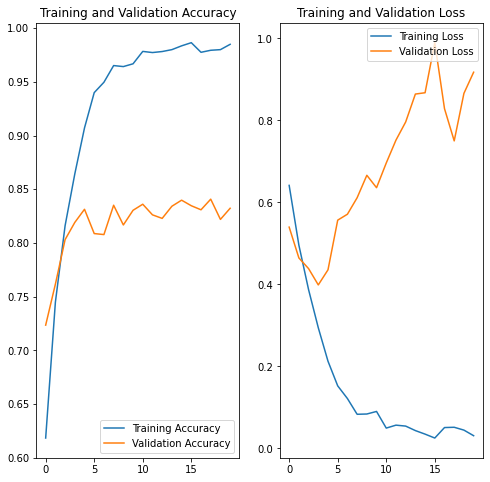

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## CNN model adding Dropout layer(s) and L2 regularizaters

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
from tensorflow.keras import regularizers

In [33]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, kernel_regularizer=regularizers.l2(0.001), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, kernel_regularizer=regularizers.l2(0.001), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, kernel_regularizer=regularizers.l2(0.001), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
266/266 [==============================] - 137s 511ms/step - loss: 0.7331 - accuracy: 0.6074 - val_loss: 0.6269 - val_accuracy: 0.7031
Epoch 2/20
266/266 [==============================] - 136s 511ms/step - loss: 0.6146 - accuracy: 0.6978 - val_loss: 0.5748 - val_accuracy: 0.7220
Epoch 3/20
266/266 [==============================] - 136s 510ms/step - loss: 0.5786 - accuracy: 0.7257 - val_loss: 0.5527 - val_accuracy: 0.7479
Epoch 4/20
266/266 [==============================] - 136s 510ms/step - loss: 0.5408 - accuracy: 0.7625 - val_loss: 0.5151 - val_accuracy: 0.7870
Epoch 5/20
266/266 [==============================] - 136s 511ms/step - loss: 0.5079 - accuracy: 0.7873 - val_loss: 0.4965 - val_accuracy: 0.8077
Epoch 6/20
266/266 [==============================] - 136s 511ms/step - loss: 0.4857 - accuracy: 0.8105 - val_loss: 0.4888 - val_accuracy: 0.8082
Epoch 7/20
266/266 [==============================] - 137s 515ms/step - loss: 0.4534 - accuracy: 0.8336 - val_loss: 0.4831 -

### Result evaluation & visualization

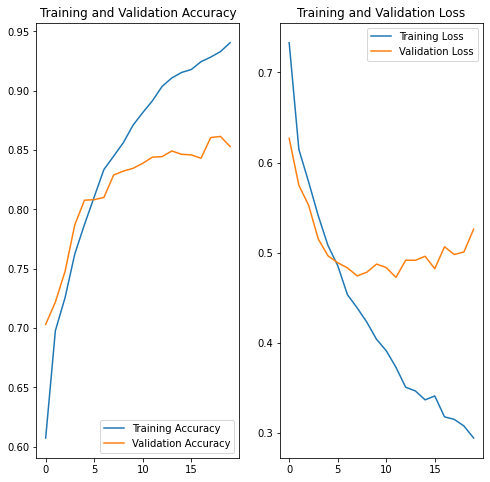

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()